# CGANs - Conditional Generative Adversarial Nets

Brief introduction to Conditional Generative Adversarial Nets or CGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training CGANs with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)

## 2. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 3. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

* **Generator**: The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

* **Discriminator**: $x$ and $y$ are presented as inputs and to a discriminative function.

### Network Design

<img src="../../img/network_design_ccgan.png" width="600"> 


### Cost Funcion

$$ \underset{G}{min} \: \underset{D}{max} \; V_{CGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$


## 4. Training CGANs with MNIST dataset, Keras and TensorFlow

CGANs implementation using fully connected and embedding layers and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * **Simple fully connected neural network**, **LeakyReLU activation** and **BatchNormalization**.
    * The input to the generator are the **normal distribution** $z$ and $y$. They are combined in joint hidden representation.
        * Embedding($y, z$).
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Simple fully connected neural network** and **LeakyReLU activation**.
    * The input to the discriminator are $x$ and $y$. They are combined in joint hidden representation.
        *  Embedding($y, x$).
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 300

### 1. Load data

#### Load libraries

In [21]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/cgan"

Mounted at /content/drive
 02_DCGAN_MNIST.ipynb   mnist-cgan.ipynb	      Train
 03_CGAN_MNIST.ipynb   'text to image code 1.ipynb'   TrainFixed_results
 data		       'text to image code 2.ipynb'


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
!pip install extra_keras_datasets
from extra_keras_datasets import emnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---
#### Embedding layer background

1/1 [==============================] - 0s 133ms/step
[[[ 0.0282515   0.03936723]
  [-0.02200018 -0.00164694]
  [ 0.04696529 -0.04569347]
  [-0.00258293  0.04543057]
  [ 0.048441    0.00141092]
  [-0.0374238  -0.02384838]
  [ 0.02959546 -0.03454015]
  [-0.0442611   0.00204685]
  [ 0.00977848  0.02106407]
  [-0.01519991 -0.02275496]
  [ 0.02934954 -0.04807893]
  [-0.00925821  0.00157667]
  [ 0.02422006  0.00640724]
  [ 0.03481938 -0.04238991]
  [ 0.00362175  0.02761197]
  [-0.00123559  0.03323858]
  [ 0.03197089 -0.01721735]
  [ 0.02688283  0.04051969]
  [ 0.00815244  0.04302248]
  [-0.03583522  0.00906061]
  [ 0.03235621 -0.0072556 ]
  [ 0.0205651   0.04456392]
  [ 0.02137101  0.04535237]
  [ 0.03202577 -0.00486028]
  [ 0.03930515  0.00991292]
  [-0.04458321  0.02767987]
  [-0.03576772  0.01197014]
  [ 0.02071222  0.04668397]
  [ 0.04457848 -0.0131071 ]
  [ 0.01789198  0.02712845]
  [-0.0031025   0.02766608]
  [ 0.03461751  0.01990504]
  [ 0.02471782  0.03960147]
  [ 0.03824672  0.00234

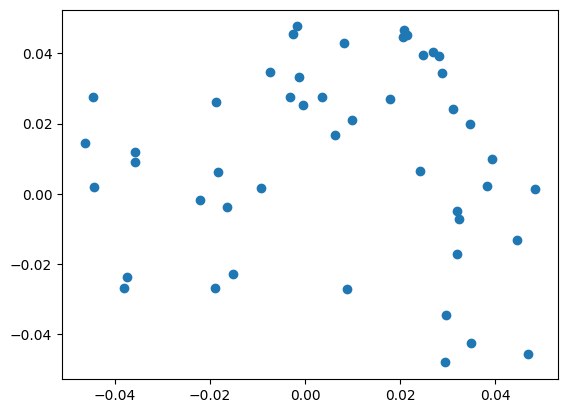

In [3]:
model = Sequential()
model.add(Embedding(47, 2))
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

# input_array = np.random.randint(10, size=(1, 10))
input_array = np.arange(0, 47).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)

# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

---
#### Getting the data

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = emnist.load_data(type='balanced')

743900280/743900280 [==============================] - 45s 0us/step


In [5]:
X_train.shape

(112800, 28, 28)

#### Explore visual data

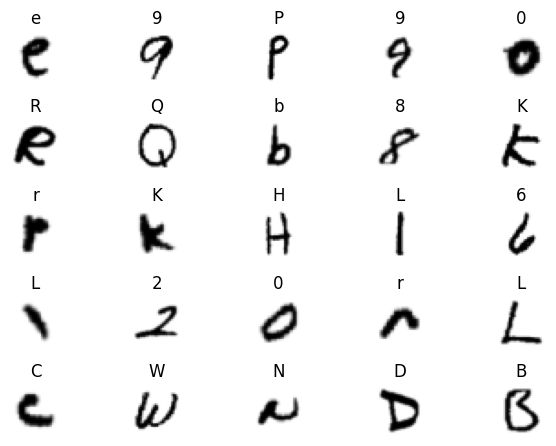

In [6]:
class_idx = ['0','1','2','3','4','5','6','7','8','9',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
             'a','b','d','e','f','g','h','n','q','r','t']
for i in range(25):
    # pick random image index from dataset to show
    index = random.randint(0, len(X_train))
    # define subplot
    plt.subplot(5, 5, 1 + i)
    plt.tight_layout()
    # turn off axis
    plt.axis('off')
    # change to grayscale as our images are in grayscale
    plt.imshow(X_train[index], cmap='gray_r')
    # show image title according to the real dataset classes
    plt.title(class_idx[y_train[index]])

#### Reshaping and normalizing the inputs

In [7]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

# reshaping the inputs
X_train = X_train.reshape(112800, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (112800, 28, 28)
y_train.shape (112800,)
X_train reshape: (112800, 784)


### 2. Define model

#### Generator

In [8]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

#### Generator model visualization

In [9]:
# prints a summary representation of your model
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                      

#### Conditional G model
The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation.

In [10]:
# Embedding condition in input layer
num_classes = 47

# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = Model([z, label], img)

#### Conditional model visualization

In [11]:
# prints a summary representation of your model
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       4700        ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 100)          0           ['embedding_1[0][0]']            
                                                                                              

#### Discriminator

In [12]:
# Discriminator network
discriminator = Sequential()

# Input layer and hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


#### Discriminator model visualization

In [13]:
# prints a summary representation of your model
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

#### Conditional D model

$x$ and $y$ are presented as inputs

In [14]:
# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_dim)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_dim,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

#### Conditional model visualization

In [15]:
# prints a summary representation of your model
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 784)       36848       ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['embedding_2[0][0]']            
                                                                                            

### 3. Compile model

#### Compile discriminator

In [16]:
# Optimizer
global_step = tf.Variable(0, trainable=False)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0002,
    decay_steps=500,
    decay_rate=0.95,
    staircase=True
)
lr = lr_schedule(global_step)

optimizer = Adam(lr=lr, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#### Combined network

In [17]:
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = Model([z, label], validity)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [18]:
# prints a summary representation of your model
d_g.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 model (Functional)             (None, 784)          588012      ['input_2[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 1)            302449      ['model[0][0]',            

### 4. Fit model


epoch = 1/100, d_loss=0.662, g_loss=0.966                                                                                                     
2/2 [==============================] - 0s 4ms/step


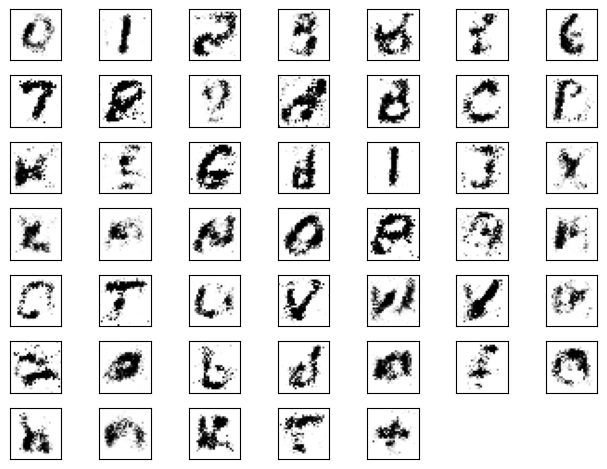

epoch = 2/100, d_loss=0.642, g_loss=0.871                                                                                                     
epoch = 3/100, d_loss=0.610, g_loss=0.958                                                                                                     
epoch = 4/100, d_loss=0.656, g_loss=0.937                                                                                                     
epoch = 5/100, d_loss=0.652, g_loss=0.948                                                                                                     
epoch = 6/100, d_loss=0.671, g_loss=0.931                                                                                                     
epoch = 7/100, d_loss=0.623, g_loss=0.996                                                                                                     
epoch = 8/100, d_loss=0.648, g_loss=0.933                                                                                                     

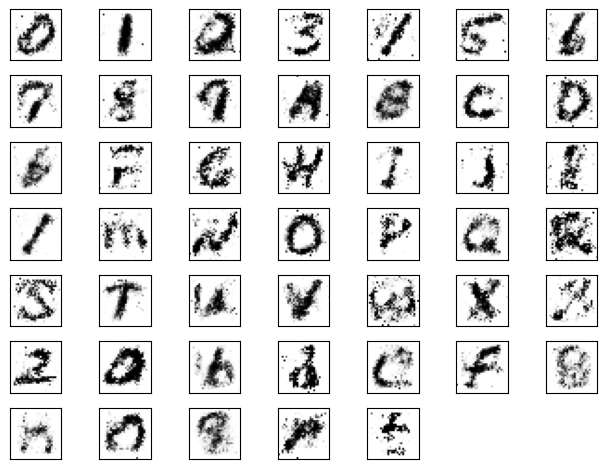

epoch = 49/100, d_loss=0.678, g_loss=0.924                                                                                                     
epoch = 50/100, d_loss=0.641, g_loss=0.923                                                                                                     
epoch = 51/100, d_loss=0.652, g_loss=0.947                                                                                                     
epoch = 52/100, d_loss=0.636, g_loss=0.926                                                                                                     
epoch = 53/100, d_loss=0.645, g_loss=0.917                                                                                                     
epoch = 54/100, d_loss=0.657, g_loss=0.937                                                                                                     
epoch = 55/100, d_loss=0.649, g_loss=0.962                                                                                              

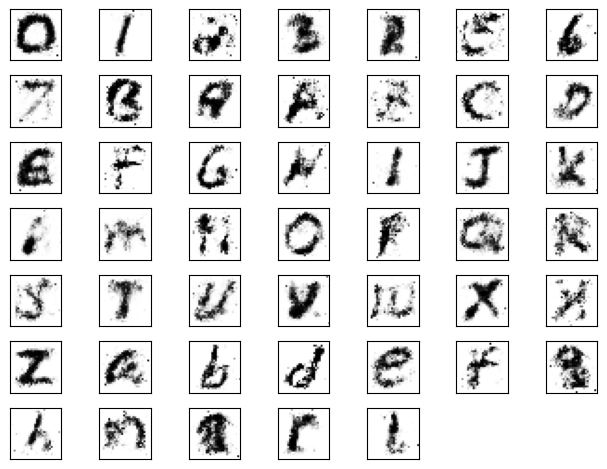

epoch = 96/100, d_loss=0.644, g_loss=0.972                                                                                                     
epoch = 97/100, d_loss=0.624, g_loss=0.995                                                                                                     
epoch = 98/100, d_loss=0.641, g_loss=0.972                                                                                                     
epoch = 99/100, d_loss=0.680, g_loss=0.985                                                                                                     
epoch = 100/100, d_loss=0.614, g_loss=0.948                                                                                                     
epoch = 101/100, d_loss=0.657, g_loss=0.947                                                                                                     


<Figure size 640x480 with 0 Axes>

In [25]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 47, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 47, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 47 == 0:
        samples = 47
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 47).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])

        for k in range(samples):
            plt.subplot(7, 7, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray_r')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()
        plt.savefig("/content/drive/My Drive/cgan//"+str(e)+".png")
    generator.save_weights('/content/drive/My Drive/cgan/cgan_emist_weight.h5')

### 5. Evaluate model

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()